In [1]:
import IPython.display as ipd
import librosa
import librosa.display
import librosa.feature
# from pydub import AudioSegment

import matplotlib.pyplot as plt
from PIL import Image

from scipy import signal

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import from_columns
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters

import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn_pandas import DataFrameMapper

from tqdm import tqdm

from concurrent.futures import ProcessPoolExecutor

import pickle

ROOT_PATH = Path("..")

# Get ids, labels, and train-test splits

In [2]:
df = pd.read_csv(ROOT_PATH / "data/raw/metadata.csv")
# svc - song vs call ids
# filter ids -> <20s, quality A & B
# svc ids -> only rows that have call or song (not both)
filter_ids = pd.read_json(ROOT_PATH / "data/raw/filter_ids.json").squeeze()
svc_ids = pd.read_json(ROOT_PATH / "data/raw/song_vs_call.json").squeeze()
svc_df = df.loc[df.id.isin(svc_ids)].copy()
# set index to id
svc_df.set_index('id', inplace=True)

with open(ROOT_PATH / "data/processed/svc_split.json") as svc_split_file:
    svc_split = json.load(svc_split_file)
    train_ids = svc_split["train_ids"]
    test_ids = svc_split["test_ids"]

In [3]:
# Add response variable
type_col = svc_df.type.str.lower().str.replace(" ", "").str.split(",")
filtered_type_col = type_col.apply(lambda l: set(l) - {"call", "song"})
svc_df["pred"] = type_col.apply(lambda l: "call" in l).astype(int)

In [4]:
## Build y train-test
# indexing all (svc_df and y_df) by id
y_df = svc_df["pred"]
y_train, y_test = (
    y_df[y_df.index.isin(train_ids)].squeeze(),
    y_df[y_df.index.isin(test_ids)].squeeze(),
)

# Featurize Audio

## Convert Audio to Timeseries, Run High-pass Filter

In [5]:
# apply butter filter
def highpass_filter(audio, sr):
    # butter_coeff_b, butter_coeff_a = signal.butter(3, 1000, btype='highpass', fs=sr) # numerator and denominator
    # butter_audio = signal.lfilter(butter_coeff_b, butter_coeff_a, audio)
    # return butter_audio
    return signal.lfilter(*signal.butter(3, 1000, btype='highpass', fs=sr), audio)

In [6]:
# unpack an mp3 or wav into df of timeseries values
def unpack_audio(id):
    try:
        audio_path = ROOT_PATH / ("data/raw/recordings/" + str(id) + ".mp3")
        # load mp3 as audio timeseries arr
        timeseries,sr = librosa.load(audio_path)
    except FileNotFoundError:
        audio_path = ROOT_PATH / ("data/raw/recordings/" + str(id) + ".wav")
        timeseries,sr = librosa.load(audio_path)

    # high-pass filter on audio timeseries
    timeseries_filt = highpass_filter(timeseries,sr)

    df = pd.DataFrame(timeseries_filt, columns=['val'])
    df.reset_index(inplace=True)
    df['id'] = id # fill col with id
    df = df.reindex(columns=['id','index','val'])
    df.columns = ['id','time','val']
    return df

In [7]:
# %%timeit
# unpack_audio(svc_ids[0])

## Extract Features

In [23]:
# select features to calculate
# features can be found here: https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.feature_calculators.fft_aggregated
manual_fc_params = {
                        "abs_energy": None,
                        "fft_aggregated": [{"aggtype":"centroid"}, {"aggtype":"kurtosis"}],
                        "root_mean_square": None,
                        "spkt_welch_density": [{"coeff":2},{"coeff":5},{"coeff":8}]
}

selected_fc_params = {
                        'standard_deviation': None,
                        'variance': None,
                        'root_mean_square': None
}

def featurize_audio(id, fc_params):
        return extract_features(unpack_audio(id), column_id='id', column_sort='time',
                        default_fc_parameters=fc_params,
                        disable_progressbar=True,
                        # we impute = remove all NaN features automatically
                        impute_function=impute,
                        # turn off parallelization
                        n_jobs=0)

In [9]:
# featurize dataset
# returns df of all combined
def featurize_set(ids, fc_params=EfficientFCParameters()):
    X_df = pd.DataFrame()
    for id in tqdm(ids):
        X_df = pd.concat([X_df,featurize_audio(id, fc_params)])
    return X_df

In [10]:
# calculate features
# takes 1 hr
# X_df = featurize_set(svc_ids, manual_fc_params)

In [11]:
# save calculated features
# X_df.to_json(ROOT_PATH / f"data/processed/audio_features_manual.json", indent=2, orient='columns')

In [12]:
# load features
X_df = pd.read_json(path_or_buf=ROOT_PATH / "data/processed/audio_features.json",orient='columns')

In [209]:
X_df

,val__abs_energy,"val__fft_aggregated__aggtype_""centroid""","val__fft_aggregated__aggtype_""kurtosis""",val__root_mean_square,val__spkt_welch_density__coeff_2,val__spkt_welch_density__coeff_5,val__spkt_welch_density__coeff_8
454911,358.220397,40462.479990,10.596966,0.030647,1.741000e-07,2.131267e-04,0.005108
418340,66.304011,38155.208216,13.535033,0.014646,8.200000e-08,1.224163e-04,0.000272
291051,4409.099474,29383.692777,26.927665,0.112822,1.026000e-07,2.451621e-04,0.008701
283618,194.438862,30328.177329,13.341530,0.029160,5.400000e-09,2.406300e-06,0.000582
209702,192.842057,25128.125979,16.318864,0.028133,8.230000e-08,1.763200e-06,0.000084
...,...,...,...,...,...,...,...
410862,2.238131,65950.256065,39.598474,0.002436,8.280000e-08,3.107400e-06,0.000009
313197,136.893167,48420.605922,56.884135,0.022562,2.160700e-06,9.892110e-05,0.000186
278258,69.776815,37022.922654,27.933719,0.013543,2.057000e-07,3.409230e-05,0.000128
277076,202.622076,76774.398330,606.192887,0.028014,2.550000e-08,7.762000e-07,0.000005


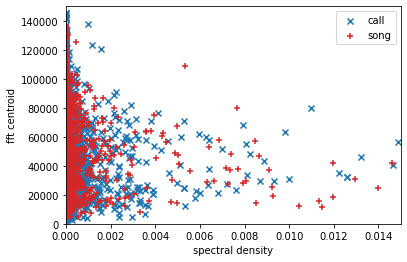

In [221]:
# plot features
full_df = X_df.copy()
full_df['label'] = y_df
full_df

ix = full_df['val__spkt_welch_density__coeff_8']
iy = full_df['val__fft_aggregated__aggtype_"centroid"'] # spectral centroid

def plot_audio_byfeat():    
    plt.scatter(ix.loc[full_df['label']==1], iy.loc[full_df['label']==1], marker='x', color='C0')
    plt.scatter(ix.loc[full_df['label']==0], iy.loc[full_df['label']==0], marker='+', color='C3')
    plt.xlim([0,.015])
    plt.ylim([0,150000])
    plt.xlabel("spectral density")
    plt.ylabel("fft centroid")
    plt.legend(['call', 'song'])
plot_audio_byfeat()

In [13]:
# get train-test split of features

X_train, X_test = (
    X_df[X_df.index.isin(train_ids)].squeeze(),
    X_df[X_df.index.isin(test_ids)].squeeze(),
)

In [14]:
# logistic regression

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

0.5910344827586207


In [222]:
# logistic regression with normalizing
from sklearn.preprocessing import StandardScaler

norm = StandardScaler()

lr_norm = LogisticRegression()
lr_norm.fit(norm.fit_transform(X_train), y_train)
print(lr_norm.score(norm.transform(X_test), y_test))

0.6103448275862069


In [261]:
# looks like the model always predicts call :(
np.where(not np.isclose(lr_norm.predict_proba(X_test),[1.,0.]).all())

(array([], dtype=int64),)

In [265]:
# compare loss and error with baseline
from sklearn.metrics import log_loss

logreg_pred = lr_norm.predict_proba(X_test)
logreg_loss = log_loss(y_test, logreg_pred)
logreg_error = (lr_norm.predict(norm.transform(X_test)) != y_test).mean() # mean error

baseline_pred = np.repeat(1, y_test.size)
baseline_loss = log_loss(y_test, baseline_pred)
baseline_error = (1 != y_test).mean()

print(logreg_loss, logreg_error)
print(baseline_loss, baseline_error)

18.746218636410145 0.3896551724137931
15.792923367532413 0.4572413793103448


# Full workflow using random smaller subset of data

In [132]:
def get_rand_split_ids(percent, train_ids, test_ids):
    # random subset of train
    train_rand_ids = np.random.choice(train_ids, size=int(len(train_ids)*percent), replace=False)
    # random subset of test
    test_rand_ids = np.random.choice(test_ids, size=int(len(test_ids)*percent), replace=False)
    return train_rand_ids, test_rand_ids

In [148]:
# test and compare multiple featurization (feature calculator) options
# useful to run on a subset of the data

def test_multiple_featurizations(train_rand_ids, test_rand_ids, *featurization_lst):
    all_rand_ids = np.concatenate((train_rand_ids, test_rand_ids))

    # lists across feature calcs:
    X_rand_lst = [] # df of features
    X_train_rand_lst = [] # df of features for train
    X_test_rand_lst = [] # df of features for test
    models_lst = [] # lr models
    scores_lst = []
    
    # make train-test splits of labels
    y_train_rand, y_test_rand = (
        y_df[y_df.index.isin(train_rand_ids)].drop(columns=["id"]).squeeze(),
        y_df[y_df.index.isin(test_rand_ids)].drop(columns=["id"]).squeeze(),
    )

    # run through full workflow for each feature calculator
    for featurization in featurization_lst:
        # featurize data from given ids
        X_rand = featurize_set(all_rand_ids, featurization)
        X_rand_lst.append(X_rand)

        # make train-test splits of featurized data
        X_train_rand, X_test_rand = (
            X_rand[X_rand.index.isin(train_rand_ids)].squeeze(),
            X_rand[X_rand.index.isin(test_rand_ids)].squeeze(),
        )
        # Why doesn't X_rand.loc[train_rand_ids,:] work? (wrong # rows)
        X_train_rand_lst.append(X_test_rand)
        X_test_rand_lst.append(X_train_rand)

        # train models
        lr = LogisticRegression()
        lr.fit(X_train_rand, y_train_rand)
        models_lst.append(lr)

        # score models
        score = lr.score(X_test_rand, y_test_rand)
        scores_lst.append(score)

    return X_rand_lst, models_lst, scores_lst

In [149]:
# generate random ids from 5% of dataset
train_rand_ids, test_rand_ids = get_rand_split_ids(.05, train_ids, test_ids)

# make train-test splits of labels
y_train_rand, y_test_rand = (
    y_df[y_df.index.isin(train_rand_ids)].drop(columns=["id"]).squeeze(),
    y_df[y_df.index.isin(test_rand_ids)].drop(columns=["id"]).squeeze(),
)

# check that we have a good distribution of value counts
print(y_train_rand.value_counts())
print(y_test_rand.value_counts())

1    111
0    106
Name: pred, dtype: int64
0    38
1    34
Name: pred, dtype: int64


In [155]:
print(len(train_rand_ids))
print(len(y_train_rand))

217
217


In [151]:
# Features to extract (options)

# presets can be found here: https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.settings.ComprehensiveFCParameters
# with more details here: https://tsfresh.readthedocs.io/en/latest/_modules/tsfresh/feature_extraction/settings.html#MinimalFCParameters
# manual_fc_params
# selected_fc_params
# EfficientFCParameters()
# ComprehensiveFCParameters()
# MinimalFCParameters()


manual_fc_params_A = {
                        "abs_energy": None,
                        "fft_aggregated": [{"aggtype":"centroid"}, {"aggtype":"kurtosis"}],
                        "root_mean_square": None,
                        "spkt_welch_density": [{"coeff":2},{"coeff":5},{"coeff":8}]
}

# manual_fc_params_B = {
#                         "abs_energy": None,
#                         "fft_aggregated": [{"aggtype":"centroid"}],
#                         "root_mean_square": None,
#                         "spkt_welch_density": [{"coeff":2},{"coeff":5},{"coeff":8}]
# }
# manual_fc_params_C = {
#                         "abs_energy": None,
#                         "fft_aggregated": [{"aggtype":"centroid"}, {"aggtype":"kurtosis"}],
#                         "root_mean_square": None,
#                         "spkt_welch_density": [{"coeff":2},{"coeff":5},{"coeff":8}],
#                         "number_crossing_m": [{"m":0}]
# }


# manual_fc_params_B = {
#                         "abs_energy": None,
#                         "fft_aggregated": [{"aggtype":"centroid"}, {"aggtype":"kurtosis"}, {"aggtype":"skew"}, {"aggtype":"variance"}],
#                         "root_mean_square": None,
#                         "spkt_welch_density": [{"coeff":2},{"coeff":5},{"coeff":8}]
# }

In [154]:
# takes 3 mins for manual, 5% of dataset
# takes 168.2 s for minimal, 5% of dataset
# takes 169s for selected (3 features), 5% of dataset
# takes 542s (9m) for all 3, 5% of dataset
# takes 13h for efficient fc, 0.5% of dataset

X_rand_lst, models_lst, scores_lst = test_multiple_featurizations(train_rand_ids, test_rand_ids, MinimalFCParameters(), selected_fc_params, manual_fc_params)
# X_rand_lst, models_lst, scores_lst = test_multiple_featurizations(train_rand_ids, test_rand_ids, manual_fc_params_A, manual_fc_params_B, manual_fc_params_C)
# X_rand_lst, models_lst, scores_lst = test_multiple_featurizations(train_rand_ids, test_rand_ids, manual_fc_params_B)
# X_rand_lst, models_lst, scores_lst = test_multiple_featurizations(train_rand_ids, test_rand_ids, EfficientFCParameters())

100%|██████████| 289/289 [02:34<00:00,  1.87it/s]


In [156]:
for score in scores_lst:
    print(score)

0.4722222222222222
0.4722222222222222
0.5


In [158]:
compare_preset_sel_manual = {'X': X_rand_lst.copy(), 'models': models_lst.copy(), 'scores': scores_lst.copy()}
# compare_manual = {'X': X_rand_ls.copy(), 'models': models_lst.copy(), 'scores': scores_lst.copy()}

In [160]:
# select good features from the first feature calculator list
# make train-test splits of featurized data
X_for_selection = X_rand_lst[0]
X_train_for_selection, X_test_for_selection = (
    X_for_selection[X_for_selection.index.isin(train_rand_ids)].squeeze(),
    X_for_selection[X_for_selection.index.isin(test_rand_ids)].squeeze(),
)

X_selected = select_features(X_train_for_selection, y_train_rand)

# get a dictionary of the good features parameters, to use again later
kind_to_fc_parameters = from_columns(X_selected)
# new_selected_fc_params = kind_to_fc_parameters['val']

{}

In [246]:
for score in compare_preset_sel_manual['scores']:
    print(score)
# for score in compare_manual['scores']:
#     print(score)

0.4722222222222222
0.4722222222222222
0.5833333333333334
